Columns in the DataFrame:
['PartNumber', 'WeekStart', 'ReceivedCount', 'ShippedCount', 'InRepair', 'RawResets', 'SeatResets', 'TotalPassengers', 'Tail', 'StandardTail', 'Airline', 'FlightDuration', 'BusinessClass', 'EconomyClass', 'Year']
Label Encoding PartNumber and Tail.
Dropping highly correlated features: ['SeatResets', 'BusinessClass', 'EconomyClass']
First few rows of the DataFrame:
   ReceivedCount  ShippedCount  InRepair  RawResets  TotalPassengers  \
0            0.0           0.0       0.0        NaN              NaN   
1            0.0           0.0       0.0        NaN              NaN   
2            0.0           0.0       0.0        NaN              NaN   
3            0.0           0.0       0.0        NaN              NaN   
4            0.0           0.0       0.0        NaN              NaN   

   FlightDuration  Year  PartNumber_encoded  Tail_encoded  
0             NaN  2013                  36           234  
1             NaN  2013                 123           

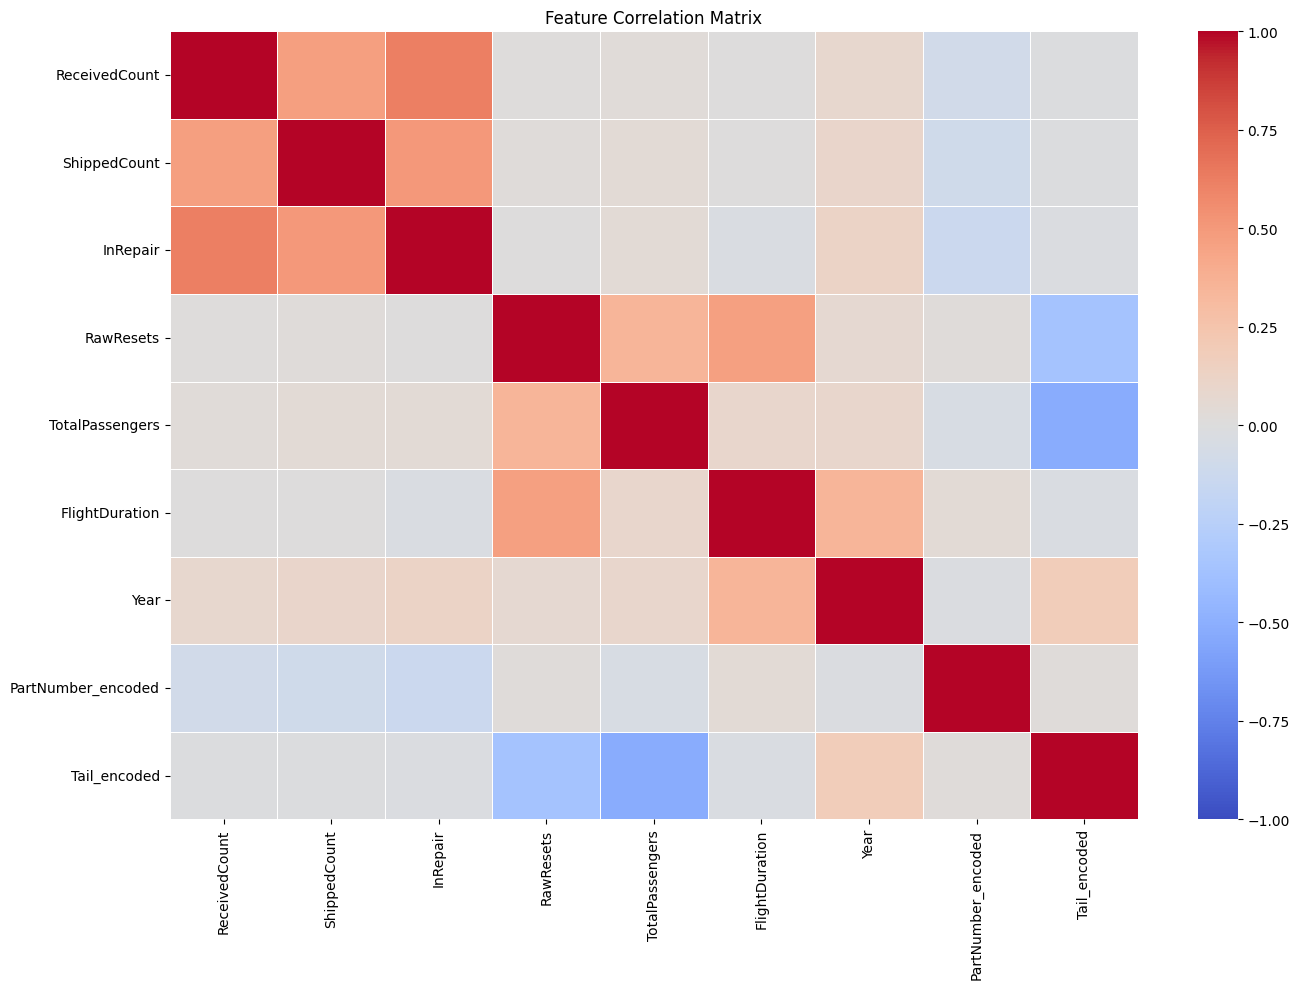

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Open the weekly sequences file
input_data_dir = os.path.join('private', 'data', 'processed')
input_file_path = os.path.join(input_data_dir, 'weekly_sequence_5_final.parquet')
preprocessed_df = pd.read_parquet(input_file_path)

# Print the columns in the DataFrame
print("Columns in the DataFrame:")
print(preprocessed_df.columns.tolist())

# Label encoding string features - partnumber, tail, linemanager
part_encoder = LabelEncoder()
tail_encoder = LabelEncoder()

print("Label Encoding PartNumber and Tail.")
preprocessed_df['Tail_filled'] = preprocessed_df['Tail'].fillna('UNKNOWN')
preprocessed_df['PartNumber_filled'] = preprocessed_df['PartNumber'].fillna('UNKNOWN')

if 'linemanager' in preprocessed_df.columns:
    line_manager_encoder = LabelEncoder()
    preprocessed_df['linemanager_filled'] = preprocessed_df['linemanager'].fillna('UNKNOWN')
    preprocessed_df['linemanager_encoded'] = line_manager_encoder.fit_transform(preprocessed_df['linemanager_filled'])
    preprocessed_df = preprocessed_df.drop(columns=['linemanager_filled'])

preprocessed_df['PartNumber_encoded'] = part_encoder.fit_transform(preprocessed_df['PartNumber_filled'])
preprocessed_df['Tail_encoded'] = tail_encoder.fit_transform(preprocessed_df['Tail_filled'])

# Drop non-encoded columns
preprocessed_df = preprocessed_df.drop(columns=['Tail_filled', 'PartNumber_filled'])
# Drop correlated features
columns_to_drop = ['weight_marketing', 'weight_contractual', 'power_marketing', 
                   'power_contractual', 'SeatResets', 'BusinessClass', 'EconomyClass']
existing_columns_to_drop = [col for col in columns_to_drop if col in preprocessed_df.columns]

print(f"Dropping highly correlated features: {existing_columns_to_drop}")
if existing_columns_to_drop:
    preprocessed_df = preprocessed_df.drop(columns=existing_columns_to_drop)

numeric_df = preprocessed_df.select_dtypes(include=[np.number])

# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
pd.set_option('display.max_columns', None)
print(numeric_df.head())
pd.reset_option('display.max_columns')

# Create Correlation Matrix
corr_matrix = numeric_df.corr()
print("Correlation matrix dimensions:", corr_matrix.shape)

# Visualize the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


In [1]:
import os
import pandas as pd
import numpy as np
import gc  
from sklearn.preprocessing import LabelEncoder
import time
from datetime import datetime
import shutil 

INPUT_FILE = 'private/data/processed/weekly_sequence_5_final.parquet'
OUTPUT_FILE = 'private/data/engineered/weekly_sequence_engineered.parquet'
CHECKPOINT_DIR = 'private/data/temp_checkpoints' 
START_STAGE = 0  # 0=beginning, 1=encoding, 2=rolling, 3=lag, 4=cumulative, 5=ratio
CLEANUP_CHECKPOINTS = True  

# Create directories if they don't exist
os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

start_time = time.time()
print(f"STARTING FEATURE ENGINEERING")
print(f"Starting from stage {START_STAGE}")

# Data Loading and Preparation
if START_STAGE <= 0:    
    print(f"Getting columns from {INPUT_FILE}")
    columns = pd.read_parquet(INPUT_FILE, columns=None).columns.tolist()
    print(f"Found {len(columns)} columns in the dataset")
    
    # Define essential columns and feature groups
    feature_groups = {
        'partnumber_level': ['RunningFleetTotal'],
        'partnumber_tail': ['RunningTailTotal', 'RunningCompanyTotal'],
        'partnumber_tail_location': ['RunningLocationTotal'],
        'rma_partnumber': ['ReceivedCount', 'ShippedCount', 'InRepair', 'Failures'],
        'tail_flight': ['RawResets', 'TotalPassengers', 'FlightDuration'],
        'shipment': ['DeliveryQuantity']
    }
    
    # Filter available columns
    for group_name, fields in feature_groups.items():
        feature_groups[group_name] = [field for field in fields if field in columns]
        print(f"{group_name} fields available: {feature_groups[group_name]}")
    
    # Combine all needed columns
    essential_columns = ['PartNumber', 'Tail', 'WeekStart']
    encode_columns = [col for col in ['PartNumber', 'Tail', 'linemanager'] if col in columns]
    additional_columns = ['InstallLocation'] if 'InstallLocation' in columns else []
    
    # Get all columns we need
    all_fields = []
    for fields in feature_groups.values():
        all_fields.extend(fields)
    
    needed_columns = list(set(essential_columns + all_fields + encode_columns + additional_columns))
    print(f"Loading {len(needed_columns)} out of {len(columns)} columns")
    
    # Check for missing essential columns
    missing_essential = [col for col in essential_columns if col not in columns]
    if missing_essential:
        print(f"ERROR: Missing essential columns: {missing_essential}")
        raise ValueError(f"Missing essential columns: {missing_essential}")
    
    # Load only needed columns
    print("Loading data...")
    preprocessed_df = pd.read_parquet(INPUT_FILE, columns=needed_columns)
    print(f"Data loaded with shape: {preprocessed_df.shape}")
    gc.collect()
    
    # Save initial checkpoint
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_0.parquet')
    preprocessed_df.to_parquet(checkpoint_path)
else:
    # Load from checkpoint
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_{START_STAGE - 1}.parquet')
    print(f"Loading checkpoint from {checkpoint_path}")
    preprocessed_df = pd.read_parquet(checkpoint_path)
    if preprocessed_df is None:
        print(f"ERROR: Checkpoint for stage {START_STAGE - 1} not found")
        raise FileNotFoundError(f"Checkpoint for stage {START_STAGE - 1} not found")
    
    feature_groups = {
        'partnumber_level': ['RunningFleetTotal'],
        'partnumber_tail': ['RunningTailTotal', 'RunningCompanyTotal'],
        'partnumber_tail_location': ['RunningLocationTotal'],
        'rma_partnumber': ['ReceivedCount', 'ShippedCount', 'InRepair', 'Failures'],
        'tail_flight': ['RawResets', 'TotalPassengers', 'FlightDuration'],
        'shipment': ['DeliveryQuantity']
    }
    # Filter available columns
    for group_name, fields in feature_groups.items():
        feature_groups[group_name] = [field for field in fields if field in preprocessed_df.columns]

if START_STAGE <= 1:
    print("Label Encoding")
    
    # Get encode columns from the dataframe
    encode_columns = [col for col in ['PartNumber', 'Tail', 'linemanager'] if col in preprocessed_df.columns]
    
    for col in encode_columns:
        print(f"Label Encoding {col}")
        encoder = LabelEncoder()
        filled_col = f"{col}_filled"
        encoded_col = f"{col}_encoded"
        
        preprocessed_df[filled_col] = preprocessed_df[col].fillna('UNKNOWN')
        preprocessed_df[encoded_col] = encoder.fit_transform(preprocessed_df[filled_col])
        preprocessed_df.drop(columns=[filled_col], inplace=True)
        gc.collect()
    
    # Sort the DataFrame
    if all(col in preprocessed_df.columns for col in ['PartNumber', 'WeekStart']):
        print("Sorting by PartNumber and WeekStart")
        preprocessed_df.sort_values(['PartNumber', 'WeekStart'], inplace=True)
        gc.collect()
    
    preprocessed_df = preprocessed_df.copy()
    gc.collect()
    
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_1.parquet')
    preprocessed_df.to_parquet(checkpoint_path)

# Settings for feature engineering
window_sizes = [4, 8, 12, 26, 52]  # Month to year
lag_periods = [1, 2, 4, 8]
feature_count = 0

if START_STAGE <= 2:
    print("Rolling Features")
    
    # Process in smaller groups to save memory
    for group_name, fields in feature_groups.items():
        print(f"Processing {group_name} rolling features ({len(fields)} fields)")
        
        for field in fields:
            if field not in preprocessed_df.columns:
                continue
            
            print(f"Processing rolling features for {field}")
            
            # Determine grouping
            if group_name == 'partnumber_level' or group_name == 'rma_partnumber':
                group_by = 'PartNumber'
            elif group_name == 'partnumber_tail':
                group_by = ['PartNumber', 'Tail']
            elif group_name == 'partnumber_tail_location':
                group_by = ['PartNumber', 'Tail', 'InstallLocation']
            elif group_name == 'tail_flight':
                group_by = 'Tail'
            elif group_name == 'shipment':
                group_by = ['PartNumber', 'Tail', 'InstallLocation']
            
            # Process one window at a time
            for window in window_sizes:
                # Mean
                col_name = f'{field}_roll{window}w_mean'
                print(f"Creating {col_name}")
                preprocessed_df[col_name] = preprocessed_df.groupby(group_by)[field].transform(
                    lambda x: x.rolling(window, min_periods=1).mean())
                feature_count += 1
                gc.collect()
                
                # Standard deviation
                has_enough_values = preprocessed_df.groupby(group_by)[field].transform(lambda x: x.count() >= 2).any()
                if has_enough_values:
                    col_name = f'{field}_roll{window}w_std'
                    print(f"Creating {col_name}")
                    preprocessed_df[col_name] = preprocessed_df.groupby(group_by)[field].transform(
                        lambda x: x.rolling(window, min_periods=2).std())
                    feature_count += 1
                    gc.collect()
                
                # Max
                col_name = f'{field}_roll{window}w_max'
                print(f"Creating {col_name}")
                preprocessed_df[col_name] = preprocessed_df.groupby(group_by)[field].transform(
                    lambda x: x.rolling(window, min_periods=1).max())
                feature_count += 1
                gc.collect()
                
                # Growth rate for partnumber_level
                if group_name == 'partnumber_level':
                    growth_col = f'{field}_roll{window}w_growth'
                    mean_col = f'{field}_roll{window}w_mean'
                    print(f"Creating {growth_col}")
                    preprocessed_df[growth_col] = preprocessed_df.groupby('PartNumber')[mean_col].transform(
                        lambda x: x.pct_change(periods=1))
                    feature_count += 1
                    gc.collect()
            
            preprocessed_df = preprocessed_df.copy()
            gc.collect()
        
        # Save checkpoint after each group
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_2_{group_name}.parquet')
        preprocessed_df.to_parquet(checkpoint_path)
    
    for field in feature_groups['tail_flight']:
        for window in window_sizes:
            col_name = f'{field}_byPart_roll{window}w_mean'
            print(f"Creating {col_name}")
            preprocessed_df[col_name] = preprocessed_df.groupby('PartNumber')[field].transform(
                lambda x: x.rolling(window, min_periods=1).mean())
            feature_count += 1
            gc.collect()
    
    for field in feature_groups['shipment']:
        for window in window_sizes:
            col_name = f'{field}_byPart_roll{window}w_mean'
            print(f"Creating {col_name}")
            preprocessed_df[col_name] = preprocessed_df.groupby('PartNumber')[field].transform(
                lambda x: x.rolling(window, min_periods=1).mean())
            feature_count += 1
            gc.collect()
    
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_2.parquet')
    preprocessed_df.to_parquet(checkpoint_path)

if START_STAGE <= 3:
    print("Lag Features")
    # Process one lag at a time
    for lag in lag_periods:
        print(f"Processing lag {lag}")
        
        # PartNumber level lag features
        for field in feature_groups['partnumber_level'] + feature_groups['rma_partnumber']:
            col_name = f'{field}_lag{lag}w'
            print(f"Creating {col_name}")
            preprocessed_df[col_name] = preprocessed_df.groupby('PartNumber')[field].transform(
                lambda x: x.shift(lag))
            feature_count += 1
            gc.collect()
        
        # PartNumber+Tail level lag features
        for field in feature_groups['partnumber_tail']:
            col_name = f'{field}_byTail_lag{lag}w'
            print(f"Creating {col_name}")
            preprocessed_df[col_name] = preprocessed_df.groupby(['PartNumber', 'Tail'])[field].transform(
                lambda x: x.shift(lag))
            feature_count += 1
            gc.collect()
        
        # Tail level lag features
        for field in feature_groups['tail_flight']:
            col_name = f'{field}_byTail_lag{lag}w'
            print(f"Creating {col_name}")
            preprocessed_df[col_name] = preprocessed_df.groupby('Tail')[field].transform(
                lambda x: x.shift(lag))
            feature_count += 1
            gc.collect()
        
        preprocessed_df = preprocessed_df.copy()
        gc.collect()
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_3_lag{lag}.parquet')
        preprocessed_df.to_parquet(checkpoint_path)
    
    # Save final lag features
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_3.parquet')
    preprocessed_df.to_parquet(checkpoint_path)

# Cumulative Features
if START_STAGE <= 4:
    print("Cumulative Features")
    
    # PartNumber level cumulative features
    for field in feature_groups['rma_partnumber']:
        col_name = f'Cumulative{field}'
        print(f"Creating {col_name}")
        preprocessed_df[col_name] = preprocessed_df.groupby('PartNumber')[field].transform(
            lambda x: x.fillna(0).cumsum())
        feature_count += 1
        gc.collect()
    
    # Tail level cumulative features
    for field in feature_groups['tail_flight']:
        col_name = f'Cumulative{field}_byTail'
        print(f"Creating {col_name}")
        preprocessed_df[col_name] = preprocessed_df.groupby('Tail')[field].transform(
            lambda x: x.fillna(0).cumsum())
        feature_count += 1
        gc.collect()
    
    preprocessed_df = preprocessed_df.copy()
    gc.collect()
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_4.parquet')
    preprocessed_df.to_parquet(checkpoint_path)

# Ratio Features
if START_STAGE <= 5:
    print("STAGE 5: Ratio Features")
    
    # Repair efficiency metrics
    required_repair_cols = ['ReceivedCount', 'ShippedCount', 'InRepair', 'RunningFleetTotal']
    if all(col in preprocessed_df.columns for col in required_repair_cols):
        print("Creating repair efficiency metrics")
        # Repair throughput ratio
        preprocessed_df['RepairThroughputRatio'] = preprocessed_df['ShippedCount'] / \
                                                 preprocessed_df['ReceivedCount'].replace(0, np.nan)
        feature_count += 1
        # Repair backlog ratio
        preprocessed_df['RepairBacklogRatio'] = preprocessed_df['InRepair'] / \
                                              preprocessed_df['RunningFleetTotal'].replace(0, np.nan)
        feature_count += 1
    else:
        missing = [col for col in required_repair_cols if col not in preprocessed_df.columns]
        print(f"Cannot create repair efficiency metrics. Missing columns: {missing}")
    
    # Flight metrics
    required_flight_cols = ['RawResets', 'FlightDuration', 'TotalPassengers']
    if all(col in preprocessed_df.columns for col in required_flight_cols):
        print("Creating flight metrics")
        # Resets per flight hour
        preprocessed_df['ResetsPerFlightHour'] = preprocessed_df['RawResets'] / \
                                               preprocessed_df['FlightDuration'].replace(0, np.nan)
        feature_count += 1
        
        # Passengers per reset
        preprocessed_df['PassengersPerReset'] = preprocessed_df['TotalPassengers'] / \
                                              preprocessed_df['RawResets'].replace(0, np.nan)
        feature_count += 1
    else:
        missing = [col for col in required_flight_cols if col not in preprocessed_df.columns]
        print(f"Cannot create flight metrics. Missing columns: {missing}")
    
    gc.collect()
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_5.parquet')
    preprocessed_df.to_parquet(checkpoint_path)

print(f"Total features created: {feature_count}")
preprocessed_df = preprocessed_df.copy()
gc.collect()

# Save the engineered features
print(f"Saving engineered features to {OUTPUT_FILE}")
preprocessed_df.to_parquet(OUTPUT_FILE)

column_info = pd.DataFrame({
    'column': preprocessed_df.columns.tolist(),
    'type': [str(preprocessed_df[col].dtype) for col in preprocessed_df.columns]
})

metadata_path = os.path.join(os.path.dirname(OUTPUT_FILE), 'feature_columns_metadata.csv')
column_info.to_csv(metadata_path, index=False)
print(f"Column metadata saved to {metadata_path}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Feature engineering completed successfully in {elapsed_time:.2f} seconds!")

# Display a summary of the final dataset
print("Final dataset summary:")
print(f"Shape: {preprocessed_df.shape}")
print(f"Memory usage: {preprocessed_df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
print(f"Column count: {len(preprocessed_df.columns)}")
print(f"Row count: {len(preprocessed_df)}")

# Clean up checkpoint files if requested
if CLEANUP_CHECKPOINTS:
    print(f"Cleaning up temporary checkpoint files from {CHECKPOINT_DIR}")
    try:
        if os.path.exists(CHECKPOINT_DIR):
            shutil.rmtree(CHECKPOINT_DIR)
            print(f"Successfully removed checkpoint directory")
    except Exception as e:
        print(f"Error removing checkpoint directory: {str(e)}")

STARTING FEATURE ENGINEERING
Starting from stage 0
Getting columns from private/data/processed/weekly_sequence_5_final.parquet
Found 15 columns in the dataset
partnumber_level fields available: []
partnumber_tail fields available: []
partnumber_tail_location fields available: []
rma_partnumber fields available: ['ReceivedCount', 'ShippedCount', 'InRepair']
tail_flight fields available: ['RawResets', 'TotalPassengers', 'FlightDuration']
shipment fields available: []
Loading 9 out of 15 columns
Loading data...
Data loaded with shape: (6909194, 9)
Label Encoding
Label Encoding PartNumber
Label Encoding Tail
Sorting by PartNumber and WeekStart
Rolling Features
Processing partnumber_level rolling features (0 fields)
Processing partnumber_tail rolling features (0 fields)
Processing partnumber_tail_location rolling features (0 fields)
Processing rma_partnumber rolling features (3 fields)
Processing rolling features for ReceivedCount
Creating ReceivedCount_roll4w_mean
Creating ReceivedCount_ro

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

INPUT_FILE = 'private/data/engineered/weekly_sequence_engineered.parquet'
OUTPUT_DIR = 'private/data/engineered/correlation_analysis'
SAMPLE_SIZE = 100000  # Number of rows to sample
CORRELATION_THRESHOLD = 0.8  # Threshold for 'strong' correlations
MAX_PLOT_COLS = 30  # Maximum number of columns for heatmap plot
EXCLUDE_PATTERNS = []  

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

def free_memory():
    n = gc.collect()
    print(f"Freed {n} objects from memory")
    return n

print("Feature Correlation Analysis")

# Load data
print(f"Loading data from {INPUT_FILE}")
if SAMPLE_SIZE:
    row_count = pd.read_parquet(INPUT_FILE, columns=['PartNumber']).shape[0]
    print(f"Total rows in dataset: {row_count}")
    
    if SAMPLE_SIZE < row_count:
        # Calculate fraction for sampling
        fraction = SAMPLE_SIZE / row_count
        df = pd.read_parquet(INPUT_FILE).sample(frac=fraction, random_state=42)
        print(f"Sampled {len(df)} rows ({fraction:.2%} of total)")
    else:
        df = pd.read_parquet(INPUT_FILE)
        print(f"Sample size >= row count, using full dataset")
else:
    df = pd.read_parquet(INPUT_FILE)
    print(f"Using full dataset: {len(df)} rows")

print(f"Data loaded with shape: {df.shape}")

# Select numeric columns and filter
numeric_df = df.select_dtypes(include=[np.number])
print(f"Selected {numeric_df.shape[1]} numeric columns out of {df.shape[1]} total columns")

if EXCLUDE_PATTERNS:
    before_count = numeric_df.shape[1]
    for pattern in EXCLUDE_PATTERNS:
        cols_to_keep = [col for col in numeric_df.columns if pattern not in col]
        numeric_df = numeric_df[cols_to_keep]
    print(f"After excluding patterns {EXCLUDE_PATTERNS}: {numeric_df.shape[1]} columns remain (removed {before_count - numeric_df.shape[1]})")

# Calculate correlation matrix
print("Calculating correlation matrix...")
corr_matrix = numeric_df.corr()
print(f"Correlation matrix shape: {corr_matrix.shape}")

# Save full correlation matrix to CSV
corr_path = os.path.join(OUTPUT_DIR, 'full_correlation_matrix.csv')
print(f"Saving full correlation matrix to {corr_path}")
corr_matrix.to_csv(corr_path)

# Find strongly correlated pairs
print(f"Finding correlations with absolute value > {CORRELATION_THRESHOLD}")
strong_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > CORRELATION_THRESHOLD:
            strong_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

# Sort by absolute correlation
strong_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

# Convert to DataFrame for easier handling
strong_corr = pd.DataFrame(strong_pairs, columns=['feature1', 'feature2', 'correlation'])

# Save strong correlations
strong_corr_path = os.path.join(OUTPUT_DIR, f'strong_correlations_above_{CORRELATION_THRESHOLD}.csv')
print(f"Saving {len(strong_corr)} strong correlations to {strong_corr_path}")
strong_corr.to_csv(strong_corr_path, index=False)

# Display top correlations
print(f"\nTop {min(20, len(strong_corr))} strongest correlations:")
pd.set_option('display.max_colwidth', None)
print(strong_corr.head(20))

# Feature groups for analysis
feature_groups = {
    'original': '_encoded',
    'roll_mean': '_roll',
    'lag': '_lag',
    'cumulative': 'Cumulative',
    'ratio': 'Ratio'
}

# Analyze correlations by feature group
for group_name, pattern in feature_groups.items():
    group_cols = [col for col in numeric_df.columns if pattern in col]
    
    if len(group_cols) == 0:
        print(f"No columns found matching pattern '{pattern}' for group '{group_name}'")
        continue
        
    print(f"\nAnalyzing feature group: {group_name} ({len(group_cols)} columns)")
    group_dir = os.path.join(OUTPUT_DIR, f'group_{group_name}')
    os.makedirs(group_dir, exist_ok=True)
    
    # Calculate correlation matrix for this group
    group_df = numeric_df[group_cols]
    group_corr = group_df.corr()
    
    # Save group correlation matrix
    group_corr_path = os.path.join(group_dir, f'{group_name}_correlation_matrix.csv')
    group_corr.to_csv(group_corr_path)
    
    # Find strong correlations in this group
    group_strong_pairs = []
    for i in range(len(group_corr.columns)):
        for j in range(i+1, len(group_corr.columns)):
            if abs(group_corr.iloc[i, j]) > CORRELATION_THRESHOLD:
                group_strong_pairs.append((
                    group_corr.columns[i],
                    group_corr.columns[j],
                    group_corr.iloc[i, j]
                ))
    
    # Sort and save strong correlations for this group
    if group_strong_pairs:
        group_strong_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
        group_strong_df = pd.DataFrame(group_strong_pairs, columns=['feature1', 'feature2', 'correlation'])
        group_strong_path = os.path.join(group_dir, f'{group_name}_strong_correlations.csv')
        group_strong_df.to_csv(group_strong_path, index=False)
        print(f"Found {len(group_strong_df)} strong correlations in {group_name} group")
        
        # Display top correlations for this group
        if len(group_strong_df) > 0:
            print(f"Top {min(5, len(group_strong_df))} strongest correlations in {group_name} group:")
            print(group_strong_df.head(5))
    else:
        print(f"No strong correlations found in {group_name} group")
    
    # Create visualization
    if len(group_cols) <= MAX_PLOT_COLS:
        print(f"Creating correlation heatmap for {group_name} group")
        plt.figure(figsize=(16, 14))
        mask = np.triu(np.ones_like(group_corr, dtype=bool))
        sns.heatmap(group_corr, annot=False, mask=mask, cmap='coolwarm', 
                    vmin=-1, vmax=1, linewidths=0.5)
        plt.title(f'{group_name.capitalize()} Feature Correlation Heatmap')
        plt.tight_layout()
        plt.savefig(os.path.join(group_dir, f'{group_name}_correlation_heatmap.png'), dpi=300)
        plt.close()

print("\nCorrelation analysis completed!")
print(f"Results saved to {OUTPUT_DIR}")


Feature Correlation Analysis
Loading data from private/data/engineered/weekly_sequence_engineered.parquet
Total rows in dataset: 6909194
Sampled 100000 rows (1.45% of total)
Data loaded with shape: (100000, 148)
Selected 145 numeric columns out of 148 total columns
Calculating correlation matrix...
Correlation matrix shape: (145, 145)
Saving full correlation matrix to private/data/engineered/correlation_analysis/full_correlation_matrix.csv
Finding correlations with absolute value > 0.8
Saving 696 strong correlations to private/data/engineered/correlation_analysis/strong_correlations_above_0.8.csv

Top 20 strongest correlations:
                       feature1                      feature2  correlation
0                      InRepair                InRepair_lag1w     0.999584
1          InRepair_roll4w_mean                InRepair_lag1w     0.999568
2          InRepair_roll4w_mean                InRepair_lag2w     0.999548
3          InRepair_roll8w_mean         InRepair_roll12w_mean   

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Configuration - Edit these variables as needed
INPUT_FILE = 'private/data/engineered/weekly_sequence_engineered.parquet'  # Corrected file path
OUTPUT_DIR = 'private/data/engineered/correlation_analysis'
SAMPLE_SIZE = 100000  # Number of rows to sample (set to None to use all data)
CORRELATION_THRESHOLD = 0.8  # Threshold for strong correlations
MAX_PLOT_COLS = 30  # Maximum number of columns for heatmap plot
EXCLUDE_PATTERNS = []  # Column patterns to exclude, e.g., ['_lag', '_roll']

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

def free_memory():
    n = gc.collect()
    print(f"Freed {n} objects from memory")
    return n

# Check if the input file exists
if not os.path.exists(INPUT_FILE):
    print(f"ERROR: Input file {INPUT_FILE} does not exist!")
    print("Available files in the directory:")
    directory = os.path.dirname(INPUT_FILE)
    if os.path.exists(directory):
        files = os.listdir(directory)
        for file in files:
            print(f" - {file}")
    else:
        print(f"Directory {directory} does not exist!")
    raise FileNotFoundError(f"Input file {INPUT_FILE} not found")

# Load data
print(f"Loading data from {INPUT_FILE}")
if SAMPLE_SIZE:
    row_count = pd.read_parquet(INPUT_FILE, columns=['PartNumber']).shape[0]
    print(f"Total rows in dataset: {row_count}")
    
    if SAMPLE_SIZE < row_count:
        # Calculate fraction for sampling
        fraction = SAMPLE_SIZE / row_count
        df = pd.read_parquet(INPUT_FILE).sample(frac=fraction, random_state=42)
        print(f"Sampled {len(df)} rows ({fraction:.2%} of total)")
    else:
        df = pd.read_parquet(INPUT_FILE)
        print(f"Sample size >= row count, using full dataset")
else:
    df = pd.read_parquet(INPUT_FILE)
    print(f"Using full dataset: {len(df)} rows")

# Display the first few rows and columns
pd.set_option('display.max_columns', None)
print("First few rows of the dataset:")
print(df.head())
pd.reset_option('display.max_columns')

print(f"Data loaded with shape: {df.shape}")
print(f"Column count: {len(df.columns)}")

# Process time-based features if they don't already exist
if 'WeekStart' in df.columns and df['WeekStart'].dtype == 'datetime64[ns]':
    if 'Month' not in df.columns:
        print("Adding Month column")
        df['Month'] = df['WeekStart'].dt.month
    if 'Quarter' not in df.columns:
        print("Adding Quarter column")
        df['Quarter'] = df['WeekStart'].dt.quarter

# Check for repair rate features
if all(col in df.columns for col in ['Tail', 'PartNumber', 'Failures']) and 'TailRepairRate' not in df.columns:
    print("Adding TailRepairRate")
    df['TailRepairRate'] = df.groupby(['Tail', 'PartNumber'])['Failures'].transform(
        lambda x: x.rolling(window=26, min_periods=1).sum() / 26
    )

if all(col in df.columns for col in ['OwnerCompanyId', 'PartNumber', 'Failures']) and 'CompanyRepairRate' not in df.columns:
    if 'OwnerCompanyId' in df.columns:
        print("Adding CompanyRepairRate")
        df['CompanyRepairRate'] = df.groupby(['OwnerCompanyId', 'PartNumber'])['Failures'].transform(
            lambda x: x.rolling(window=26, min_periods=1).sum() / 26
        )

# Select numeric columns and filter out specified patterns
numeric_df = df.select_dtypes(include=[np.number])
print(f"Selected {numeric_df.shape[1]} numeric columns out of {df.shape[1]} total columns")

if EXCLUDE_PATTERNS:
    before_count = numeric_df.shape[1]
    for pattern in EXCLUDE_PATTERNS:
        cols_to_keep = [col for col in numeric_df.columns if pattern not in col]
        numeric_df = numeric_df[cols_to_keep]
    print(f"After excluding patterns {EXCLUDE_PATTERNS}: {numeric_df.shape[1]} columns remain (removed {before_count - numeric_df.shape[1]})")

free_memory()

# Calculate correlation matrix
print("Calculating correlation matrix...")
corr_matrix = numeric_df.corr()
print(f"Correlation matrix shape: {corr_matrix.shape}")

# Save full correlation matrix to CSV
corr_path = os.path.join(OUTPUT_DIR, 'full_correlation_matrix.csv')
print(f"Saving full correlation matrix to {corr_path}")
corr_matrix.to_csv(corr_path)

# Find strongly correlated pairs
print(f"Finding correlations with absolute value > {CORRELATION_THRESHOLD}")
strong_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > CORRELATION_THRESHOLD:
            strong_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

# Sort by absolute correlation
strong_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

# Convert to DataFrame for easier handling
strong_corr = pd.DataFrame(strong_pairs, columns=['feature1', 'feature2', 'correlation'])

# Save strong correlations
strong_corr_path = os.path.join(OUTPUT_DIR, f'strong_correlations_above_{CORRELATION_THRESHOLD}.csv')
print(f"Saving {len(strong_corr)} strong correlations to {strong_corr_path}")
strong_corr.to_csv(strong_corr_path, index=False)

# Display top correlations
print(f"\nTop {min(20, len(strong_corr))} strongest correlations:")
pd.set_option('display.max_colwidth', None)
print(strong_corr.head(20))

# Feature groups for analysis
feature_groups = {
    'original': '_encoded',
    'roll_mean': '_roll',
    'lag': '_lag',
    'cumulative': 'Cumulative',
    'ratio': 'Ratio',
    'repair_rate': 'RepairRate',
    'time_features': ['Month', 'Quarter']
}

# Analyze correlations by feature group
for group_name, pattern in feature_groups.items():
    if isinstance(pattern, list):
        group_cols = [col for col in numeric_df.columns if col in pattern]
    else:
        group_cols = [col for col in numeric_df.columns if pattern in col]
    
    if len(group_cols) == 0:
        print(f"No columns found matching pattern '{pattern}' for group '{group_name}'")
        continue
        
    print(f"\nAnalyzing feature group: {group_name} ({len(group_cols)} columns)")
    
    # Create directory for this group
    group_dir = os.path.join(OUTPUT_DIR, f'group_{group_name}')
    os.makedirs(group_dir, exist_ok=True)
    
    # Calculate correlation matrix for this group
    group_df = numeric_df[group_cols]
    group_corr = group_df.corr()
    
    # Save group correlation matrix
    group_corr_path = os.path.join(group_dir, f'{group_name}_correlation_matrix.csv')
    group_corr.to_csv(group_corr_path)
    
    # Find strong correlations within this group
    group_strong_pairs = []
    for i in range(len(group_corr.columns)):
        for j in range(i+1, len(group_corr.columns)):
            if abs(group_corr.iloc[i, j]) > CORRELATION_THRESHOLD:
                group_strong_pairs.append((
                    group_corr.columns[i],
                    group_corr.columns[j],
                    group_corr.iloc[i, j]
                ))
    
    # Sort and save strong correlations for this group
    if group_strong_pairs:
        group_strong_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
        group_strong_df = pd.DataFrame(group_strong_pairs, columns=['feature1', 'feature2', 'correlation'])
        group_strong_path = os.path.join(group_dir, f'{group_name}_strong_correlations.csv')
        group_strong_df.to_csv(group_strong_path, index=False)
        print(f"Found {len(group_strong_df)} strong correlations in {group_name} group")
        
        # Display top correlations for this group
        if len(group_strong_df) > 0:
            print(f"Top {min(5, len(group_strong_df))} strongest correlations in {group_name} group:")
            print(group_strong_df.head(5))
    else:
        print(f"No strong correlations found in {group_name} group")
    
    # Create visualization for the matrix
    if len(group_cols) <= MAX_PLOT_COLS:
        print(f"Creating correlation heatmap for {group_name} group")
        plt.figure(figsize=(16, 14))
        mask = np.triu(np.ones_like(group_corr, dtype=bool))
        sns.heatmap(group_corr, annot=False, mask=mask, cmap='coolwarm', 
                    vmin=-1, vmax=1, linewidths=0.5)
        plt.title(f'{group_name.capitalize()} Feature Correlation Heatmap')
        plt.tight_layout()
        plt.savefig(os.path.join(group_dir, f'{group_name}_correlation_heatmap.png'), dpi=300)
        plt.close()

# Analyze correlations of features with Failures and repair rates
failure_related = ['Failures', 'TailRepairRate', 'CompanyRepairRate']
available_failure_features = [f for f in failure_related if f in numeric_df.columns]

if available_failure_features:
    print("\nAnalyzing Correlations with Failure-Related Features")
    failure_dir = os.path.join(OUTPUT_DIR, 'failure_analysis')
    os.makedirs(failure_dir, exist_ok=True)
    
    for target in available_failure_features:
        print(f"\nAnalyzing correlations with {target}")
        
        # Get correlations with target
        if target in corr_matrix.columns:
            target_corr = corr_matrix[target].drop(target)
            
            # Sort by absolute correlation
            target_corr_abs = target_corr.abs().sort_values(ascending=False)
            
            # Convert to DataFrame for easier handling
            target_importance = pd.DataFrame({
                'feature': target_corr_abs.index,
                'correlation': [target_corr[feat] for feat in target_corr_abs.index]
            })
            
            # Save to CSV
            target_path = os.path.join(failure_dir, f'{target}_correlations.csv')
            target_importance.to_csv(target_path, index=False)
            
            # Display top correlations
            print(f"Top 10 features correlated with {target}:")
            print(target_importance.head(10))
            
            # Create visualization
            plt.figure(figsize=(10, 8))
            top_n = min(20, len(target_importance))
            sns.barplot(x='correlation', y='feature', data=target_importance.head(top_n))
            plt.title(f'Top {top_n} Features Correlated with {target}')
            plt.tight_layout()
            plt.savefig(os.path.join(failure_dir, f'{target}_correlations.png'), dpi=300)
            plt.close()

print("\nCorrelation analysis completed!")
print(f"Results saved to {OUTPUT_DIR}")

Loading data from private/data/engineered/weekly_sequence_engineered.parquet
Total rows in dataset: 6909194
Sampled 100000 rows (1.45% of total)
First few rows of the dataset:
         InRepair  RawResets  FlightDuration  ReceivedCount  WeekStart  \
932385        0.0        NaN             NaN            0.0 2022-07-11   
3890939       1.0        NaN             NaN            1.0 2021-12-13   
6423226       NaN        NaN             NaN            NaN 2034-10-30   
2716595       NaN        NaN             NaN            NaN 2031-12-08   
5824051       NaN        NaN             NaN            NaN 2031-02-10   

         TotalPassengers  ShippedCount    PartNumber     Tail  \
932385               NaN           0.0  1503-47-1062   A6-FMI   
3890939              NaN           0.0    00-5351-01   CS-TKY   
6423226              NaN           NaN       1503-99  B-18121   
2716595              NaN           NaN   1503-98-105  B-58206   
5824051              NaN           NaN  1503-281-120  

In [2]:
import pandas as pd

# Path to the engineered data file
engineered_data_file = 'private/data/engineered/weekly_sequence_engineered.parquet'

# Load the data
df = pd.read_parquet(engineered_data_file)

# Print 100 random rows
print("Displaying 100 random rows from the dataset:")
pd.set_option('display.max_columns', None)  # Show all columns
print(df.sample(n=100, random_state=42))
pd.reset_option('display.max_columns')  # Reset to default

Displaying 100 random rows from the dataset:
         InRepair  RawResets  FlightDuration  ReceivedCount  WeekStart  \
932385        0.0        NaN             NaN            0.0 2022-07-11   
3890939       1.0        NaN             NaN            1.0 2021-12-13   
6423226       NaN        NaN             NaN            NaN 2034-10-30   
2716595       NaN        NaN             NaN            NaN 2031-12-08   
5824051       NaN        NaN             NaN            NaN 2031-02-10   
...           ...        ...             ...            ...        ...   
3471915       0.0        NaN             NaN            0.0 2019-12-16   
5521954       NaN        NaN             NaN            NaN 2029-07-23   
6142432       NaN        NaN             NaN            NaN 2032-12-27   
3983065       0.0        NaN             NaN            0.0 2022-05-09   
4712911       NaN        NaN             NaN            NaN 2025-08-25   

         TotalPassengers  ShippedCount    PartNumber     Tail  \
9